In [50]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [51]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [52]:
%matplotlib widget

In [53]:
xp.controls.outputlog = 0
xp.controls.threads = 1
xp.controls.scaling = 0
xp.controls.presolve = 0
xp.controls.feastol = 1.e-7
xp.controls.optimalitytol = 1.e-7
xp.setOutputEnabled(False)

In [84]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/4-mingen/20240624_1447_ERAA24_TY_2028_AGG_v_8_8"
# output_path = study_path+"/output/20241015-0934eco-modified_inflow_right_costs"
output_path = study_path+"/output/20241015-0941eco-right_costs"

In [85]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

def modify_objective(model, u):
    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
    model.chgrhs(binding_id,[u])
    return(model)

def milp_version(model):
    vars = model.getVariable()
    interger_vars = [i for i in range(len(vars)) if vars[i].name.strip().split("::")[0] in ['NODU', 'NumberBreakingDownDispatchableUnits', 'NumberStartingDispatchableUnits','NumberStoppingDispatchableUnits']]
    for i in interger_vars:
        model.chgcoltype([vars[i]],'I')
    return(model)

In [86]:
m = retrieve_problem(7,13,output_path,itr=1)

In [87]:
vars = m.getVariable()
len(vars)

6552

In [88]:
level = [v for v in vars if "Level" in v.name]
overflow = [v for v in vars if "Overflow" in v.name]
# level

In [38]:
m.chgobj(level,[-1e-6]*len(level))
m.chgobj(overflow,[2]*len(overflow))

In [73]:
cons = m.getConstraint()
len(cons)

1700

In [40]:
# m.chgrhs([c for c in cons if c.name == "HydroPower::area<2_cz00_hydro_open>::week<12>                                                   "],[34272+33637])

In [89]:
m.solve()
m.getObjVal()

109762198.68574867

In [90]:
m.getProbStatusString()

'lp_optimal'

In [91]:
df_vars = pd.DataFrame(vars, columns=["names"])
df_vars["split"] = df_vars["names"].apply(lambda x:x.name.strip().split("::"))
df_vars["name_var"] = df_vars["split"].apply(lambda x:x[0])
df_vars["antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[0])
df_vars["name_antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[1].split(">")[0])
df_vars["subobject"] = df_vars["split"].apply(lambda x:x[2] if len(x)>=4 else "None")
df_vars["time"] = df_vars["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_vars["time_type"] = df_vars["split"].apply(lambda x:x[-1].split("<")[0])
coltype = []
m.getcoltype(coltype, 0, m.attributes.cols - 1)
df_vars['coltype'] = coltype
bounds = []
m.getlb(bounds, 0, m.attributes.cols - 1)
df_vars['lb'] = bounds
bounds = []
m.getub(bounds, 0, m.attributes.cols - 1)
df_vars['ub'] = bounds
objcoef = []
m.getobj(objcoef,0,m.attributes.cols-1)
df_vars= df_vars.assign(coeff=[objcoef[i] for i in range(m.attributes.cols)])
df_vars = df_vars.assign(sol=[m.getSolution(i) for i in range(m.attributes.cols)])
# df_vars = df_vars.assign(obj = lambda x: np.round(df_vars['sol'],6)*np.round(df_vars['coeff'],6))

In [92]:
df_vars

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff,sol
0,NTCDirect::link<2_cz00_hydro_open$$cz00>::hour...,"[NTCDirect, link<2_cz00_hydro_open$$cz00>, hou...",NTCDirect,link,2_cz00_hydro_open$$cz00,None,2016,hour,C,-599.0,2.040000e+02,0.000000,204.0
1,NTCDirect::link<3_es00_hydro_res$$es00>::hour<...,"[NTCDirect, link<3_es00_hydro_res$$es00>, hour...",NTCDirect,link,3_es00_hydro_res$$es00,None,2016,hour,C,0.0,1.000000e+06,0.000000,1547.0
2,PositiveUnsuppliedEnergy::area<2_cz00_hydro_op...,"[PositiveUnsuppliedEnergy, area<2_cz00_hydro_o...",PositiveUnsuppliedEnergy,area,2_cz00_hydro_open,None,2016,hour,C,0.0,1.000000e-05,4999.999498,0.0
3,NegativeUnsuppliedEnergy::area<2_cz00_hydro_op...,"[NegativeUnsuppliedEnergy, area<2_cz00_hydro_o...",NegativeUnsuppliedEnergy,area,2_cz00_hydro_open,None,2016,hour,C,0.0,1.000000e+20,0.999498,0.0
4,PositiveUnsuppliedEnergy::area<3_es00_hydro_re...,"[PositiveUnsuppliedEnergy, area<3_es00_hydro_r...",PositiveUnsuppliedEnergy,area,3_es00_hydro_res,None,2016,hour,C,0.0,1.000000e-05,5000.000515,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6547,Overflow::area<2_cz00_hydro_open>::hour<2183> ...,"[Overflow, area<2_cz00_hydro_open>, hour<2183>]",Overflow,area,2_cz00_hydro_open,None,2183,hour,C,0.0,5.083333e+00,2.000000,0.0
6548,HydProd::area<3_es00_hydro_res>::hour<2183> ...,"[HydProd, area<3_es00_hydro_res>, hour<2183>]",HydProd,area,3_es00_hydro_res,None,2183,hour,C,324.0,1.547000e+03,0.000507,1547.0
6549,HydProd::area<cz00>::hour<2183> ...,"[HydProd, area<cz00>, hour<2183>]",HydProd,area,cz00,None,2183,hour,C,20.0,4.000000e+02,0.000725,20.0
6550,HydroLevel::area<cz00>::hour<2183> ...,"[HydroLevel, area<cz00>, hour<2183>]",HydroLevel,area,cz00,None,2183,hour,C,0.0,1.855000e+03,-0.000001,1855.0


In [93]:
df_vars["name_var"].unique()

array(['NTCDirect', 'PositiveUnsuppliedEnergy',
       'NegativeUnsuppliedEnergy', 'DispatchableProduction', 'HydProd',
       'Pumping', 'HydroLevel', 'Overflow'], dtype=object)

In [94]:
df_vars.loc[df_vars.name_var.isin(["Overflow"]),"sol"].sum()

0.0

In [95]:
df_vars.loc[df_vars.name_var.isin(['NegativeUnsuppliedEnergy']),"sol"].sum()

1634386.6517440914

<Axes: xlabel='time', ylabel='sol'>

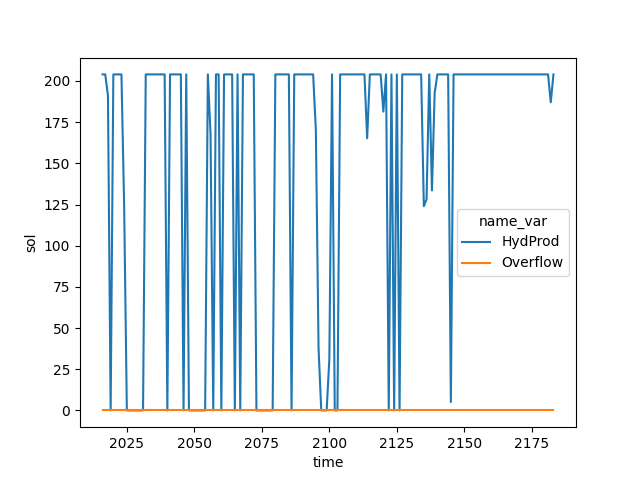

In [96]:
# plt.close()
plt.figure()
sns.lineplot(data=df_vars[df_vars.name_var.isin(['HydProd',"Overflow"])&(df_vars.name_antares_object=="2_cz00_hydro_open")],x="time",y="sol",hue="name_var")

<Axes: xlabel='time', ylabel='sol'>

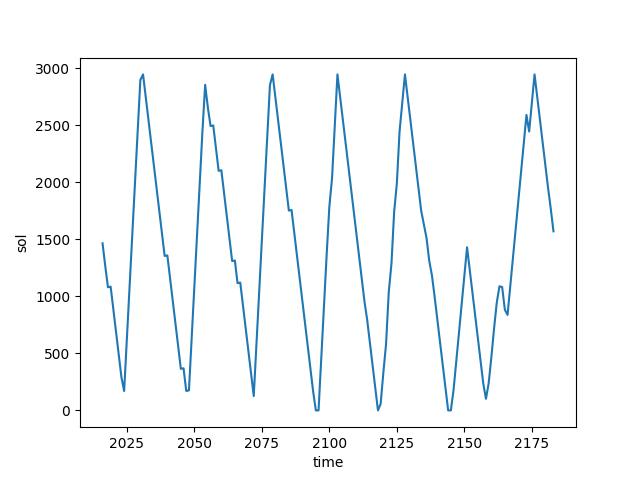

In [97]:
# plt.close()
plt.figure()
sns.lineplot(data=df_vars[df_vars.name_var.isin(['HydroLevel'])&(df_vars.name_antares_object=="2_cz00_hydro_open")],x="time",y="sol")

In [116]:
df_vars[df_vars.name_var.isin(["Overflow",'HydroLevel'])&(df_vars.name_antares_object=="2_cz00_hydro_open")&(df_vars.time>=2028)&(df_vars.time<=2032)]

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff,sol
501,HydroLevel::area<2_cz00_hydro_open>::hour<2028...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2028>]",HydroLevel,area,2_cz00_hydro_open,None,2028,hour,C,0.0,2945.00,-10.0,2945.00
502,Overflow::area<2_cz00_hydro_open>::hour<2028> ...,"[Overflow, area<2_cz00_hydro_open>, hour<2028>]",Overflow,area,2_cz00_hydro_open,None,2028,hour,C,0.0,421.75,2.0,217.75
540,HydroLevel::area<2_cz00_hydro_open>::hour<2029...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2029>]",HydroLevel,area,2_cz00_hydro_open,None,2029,hour,C,0.0,2945.00,-10.0,2945.00
541,Overflow::area<2_cz00_hydro_open>::hour<2029> ...,"[Overflow, area<2_cz00_hydro_open>, hour<2029>]",Overflow,area,2_cz00_hydro_open,None,2029,hour,C,0.0,421.75,2.0,217.75
579,HydroLevel::area<2_cz00_hydro_open>::hour<2030...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2030>]",HydroLevel,area,2_cz00_hydro_open,None,2030,hour,C,0.0,2945.00,-10.0,2945.00
580,Overflow::area<2_cz00_hydro_open>::hour<2030> ...,"[Overflow, area<2_cz00_hydro_open>, hour<2030>]",Overflow,area,2_cz00_hydro_open,None,2030,hour,C,0.0,421.75,2.0,217.75
618,HydroLevel::area<2_cz00_hydro_open>::hour<2031...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2031>]",HydroLevel,area,2_cz00_hydro_open,None,2031,hour,C,0.0,2945.00,-10.0,2945.00
619,Overflow::area<2_cz00_hydro_open>::hour<2031> ...,"[Overflow, area<2_cz00_hydro_open>, hour<2031>]",Overflow,area,2_cz00_hydro_open,None,2031,hour,C,0.0,421.75,2.0,217.75
657,HydroLevel::area<2_cz00_hydro_open>::hour<2032...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2032>]",HydroLevel,area,2_cz00_hydro_open,None,2032,hour,C,0.0,2945.00,-10.0,2945.00
658,Overflow::area<2_cz00_hydro_open>::hour<2032> ...,"[Overflow, area<2_cz00_hydro_open>, hour<2032>]",Overflow,area,2_cz00_hydro_open,None,2032,hour,C,0.0,421.75,2.0,217.75


In [431]:
df_cons = pd.DataFrame(cons, columns=["names"])
df_cons["split"] = df_cons["names"].apply(lambda x:x.name.strip().split("::"))
df_cons["name_cons"] = df_cons["split"].apply(lambda x:x[0])
df_cons["antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[0])
df_cons["name_antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[1].split(">")[0] if len(x[1].split("<"))>=2 else "None")
df_cons["time"] = df_cons["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_cons["time_type"] = df_cons["split"].apply(lambda x:x[-1].split("<")[0])
rhs = []
m.getrhs(rhs, 0, m.attributes.rows - 1)
df_cons["rhs"] = rhs

In [432]:
df_cons

,names,split,name_cons,antares_object,name_antares_object,time,time_type,rhs
0,AreaBalance::area<2_cz00_hydro_open>::hour<201...,"[AreaBalance, area<2_cz00_hydro_open>, hour<20...",AreaBalance,area,2_cz00_hydro_open,2016,hour,0.000000
1,FictiveLoads::area<2_cz00_hydro_open>::hour<20...,"[FictiveLoads, area<2_cz00_hydro_open>, hour<2...",FictiveLoads,area,2_cz00_hydro_open,2016,hour,0.000000
2,AreaBalance::area<3_es00_hydro_res>::hour<2016...,"[AreaBalance, area<3_es00_hydro_res>, hour<2016>]",AreaBalance,area,3_es00_hydro_res,2016,hour,0.000000
3,FictiveLoads::area<3_es00_hydro_res>::hour<201...,"[FictiveLoads, area<3_es00_hydro_res>, hour<20...",FictiveLoads,area,3_es00_hydro_res,2016,hour,0.000000
4,AreaBalance::area<cz00>::hour<2016> ...,"[AreaBalance, area<cz00>, hour<2016>]",AreaBalance,area,cz00,2016,hour,-5841.200000
...,...,...,...,...,...,...,...,...
1695,AreaHydroLevel::area<cz00>::hour<2181> ...,"[AreaHydroLevel, area<cz00>, hour<2181>]",AreaHydroLevel,area,cz00,2181,hour,107.666667
1696,AreaHydroLevel::area<2_cz00_hydro_open>::hour<...,"[AreaHydroLevel, area<2_cz00_hydro_open>, hour...",AreaHydroLevel,area,2_cz00_hydro_open,2182,hour,5.083333
1697,AreaHydroLevel::area<cz00>::hour<2182> ...,"[AreaHydroLevel, area<cz00>, hour<2182>]",AreaHydroLevel,area,cz00,2182,hour,107.666667
1698,AreaHydroLevel::area<2_cz00_hydro_open>::hour<...,"[AreaHydroLevel, area<2_cz00_hydro_open>, hour...",AreaHydroLevel,area,2_cz00_hydro_open,2183,hour,5.083333


In [433]:
df_cons["name_cons"].unique()

array(['AreaBalance', 'FictiveLoads', 'BC_cz00_dsr_pb_500',
       'BC_es00_dsr_pb_20000', 'HydroPower', 'MinHydroPower',
       'MaxHydroPower', 'MaxPumping', 'AreaHydroLevel'], dtype=object)

In [83]:
m.write("problem.lp","l")